# Определение перспективного тарифа для телеком компании

# Содержание проекта:

[1. Описание данных](#step1)

[2. Общая инфорация](#step2)

[3. Подготовка данных](#step3)

[4. Анализ данных](#step4)

[5. Проверка гипотез](#step5)

[6. Общий вывод](#step6)

## Описание данных <a id='step1'></a>

**Таблица users (информация о пользователях):**
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

**Таблица calls (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

**Тариф «Смарт»**

- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

# Шаг 1. Общая информация <a id='step2'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from scipy import stats as st

**Ознакомимся с общей информацией о данных, определим проблемные участки, наметим план по предобработке данных:**

In [2]:
users = pd.read_csv('/datasets/users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В таблице о пользователях пропусков нет, в столбцах **`reg_date`** - тип данных object, нужно будет перевести в формат даты. Пропуски в **`churn_date`** означают, что тариф действовал на момент выгрузки данных. Данный столбец не участвует в дальнейшем анализе, поэтому можно оставить пропуски. Название столбца **`tariff`** можно изменить на **`tariff_name`**, как в таблице с тарифами, так как информация в этих столбцах объединяет эти две таблицы.
Также для дальнейшего анализа нам потребуется сравнивать Москву с другими регионами. Для этого на этапе подготовки данных в столбце **`city`** все населенные пункты, которые не Москва, заменим на "Другой регион".

In [4]:
calls = pd.read_csv('/datasets/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице о звонках пропусков нет, в столбце **`call_date`** - тип данных object, нужно будет перевести в формат даты, а также на следующем этапе добавить столбце **`month`**, он потребуется для дальнейшего анализа, **`duration`** - вещественный тип данных преобразовать в целочисленный, с округлением в большую сторону, так как по условиям тарифов - даже одна секунда разговора приравнивается к 1 минуте.

In [6]:
messages = pd.read_csv('/datasets/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В таблице о сообщениях пропусков нет, в столбце **`message_date`** - тип данных object, нужно будет перевести в формат даты, а также на следующем этапе добавить столбце **`month`**, он потребуется для дальнейшего анализа.

In [8]:
internet = pd.read_csv('/datasets/internet.csv')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В таблице об интернет-сессиях пропусков нет, в столбце **`session_date`** - тип данных object, нужно будет перевести в формат даты, а также на следующем этапе добавить столбце **`month`**, он потребуется для дальнейшего анализа, **`mb_used`** -мегабайты перевести в гигабайты, вещественный тип данных преобразовать в целочисленный, с округлением в большую сторону по услоиям тарифа, изменить название столбца на **`gb_used`**

In [10]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В таблице с описанием тарифов присутствует вся информация, типы данных соответтсвуют содержанию. Только мегабайты перевести в гигабайты, так как по условиям тарифа считаются целые гигабайты и стоимость указана за гигабайты. Изменить название столбца **`mb_per_month_included`** на **`gb_per_month_included`**

# Шаг 2. Подготовка данных <a id='step3'></a>

Итак, на предыдущем шаге, мы выяснили, что нам нужно преобразовать в формат даты, мегабайты перевести в гигабайты, округлить минуты и гагабайты в большую сторону, переименовать столбцы, и города поделить на две группы: Москва или Другой регион.

In [12]:
#преобразование в формат даты
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [13]:
#округление в большую сторону и мегабайты в гигабайты
calls['duration'] = np.ceil(calls['duration']).astype('int')
internet['mb_used'] = np.ceil(np.ceil(internet['mb_used']) / 1024)
tariffs['mb_per_month_included'] = np.ceil(tariffs['mb_per_month_included']/1024).astype('int')

In [14]:
#переименуем столбцы с мегабайтами в гигабайты
internet.rename(columns={'mb_used':'gb_used'},inplace=True)
tariffs.rename(columns={'mb_per_month_included':'gb_per_month_included'},inplace=True)

In [15]:
#в таблице Users переименуем столбец tariff в tariff_name как в таблице tariffs
users.rename(columns={'tariff':'tariff_name'},inplace=True)

In [16]:
#укрупняем группы, если city в таблице users не равен Москва, то "Другой регион"
users['city'] = users['city'].apply(lambda x: 'Москва' if x =='Москва' else 'Другой регион')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name
0,1000,52,2018-05-25,Другой регион,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2018-11-01,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2018-06-17,Другой регион,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2018-08-17,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2018-05-14,Другой регион,Татьяна,Авдеенко,2018-05-14,ultra


Добавим столбцы:

In [17]:
#добавление столбца месяц в таблицы, для агрегации данных по месяцам
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [18]:
#количество звонков и израсходованных минут по месяцам
calls_pivot = calls.pivot_table(index=['user_id','month'], values='duration', aggfunc=['count','sum'])
calls_pivot = calls_pivot.reset_index(level = 'month')
calls_pivot.columns = ['month','count_calls','duration_calls']
calls_pivot.head()

,month,count_calls,duration_calls
user_id,,,
1000,5,22,159
1000,6,43,172
1000,7,47,340
1000,8,52,408
1000,9,58,466


In [19]:
# количество отпралвенных сообщений по месяцам
messages_pivot = messages.pivot_table(index=['user_id','month'], values='message_date', aggfunc='count')
messages_pivot = messages_pivot.reset_index(level = 'month')
messages_pivot.columns = ['month','count_messages']
messages_pivot.head()

,month,count_messages
user_id,,
1000,5,22
1000,6,60
1000,7,75
1000,8,81
1000,9,57


In [20]:
# количество исзрасходованных гигабайт по месяцам
internet_pivot = internet.pivot_table(index=['user_id','month'], values='gb_used', aggfunc='sum')
internet_pivot = internet_pivot.reset_index(level = 'month')
internet_pivot.head()

,month,gb_used
user_id,,
1000,5,4.0
1000,6,49.0
1000,7,28.0
1000,8,27.0
1000,9,26.0


Для расчета выручки объединим полученные сводные таблицы, с информацией о пользователях и тарифах:

In [21]:
#users_all = calls_pivot.merge(users[['user_id','city','tariff_name']], on=['user_id'],how='outer')
users_all = calls_pivot.merge(messages_pivot,on=['user_id','month'],how='outer')
users_all = users_all.merge(internet_pivot,on=['user_id','month'],how='outer')
users_all = users_all.merge(users[['user_id','city','tariff_name']],on=['user_id'],how='left')
users_all = users_all.merge(tariffs,on=['tariff_name'],how='left')
users_all.head()

,user_id,month,count_calls,duration_calls,count_messages,gb_used,city,tariff_name,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159.0,22.0,4.0,Другой регион,ultra,1000,30,3000,1950,150,1,1
1,1000,6,43.0,172.0,60.0,49.0,Другой регион,ultra,1000,30,3000,1950,150,1,1
2,1000,7,47.0,340.0,75.0,28.0,Другой регион,ultra,1000,30,3000,1950,150,1,1
3,1000,8,52.0,408.0,81.0,27.0,Другой регион,ultra,1000,30,3000,1950,150,1,1
4,1000,9,58.0,466.0,57.0,26.0,Другой регион,ultra,1000,30,3000,1950,150,1,1


In [22]:
users_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
user_id                  3214 non-null int64
month                    3214 non-null int64
count_calls              3174 non-null float64
duration_calls           3174 non-null float64
count_messages           2717 non-null float64
gb_used                  3203 non-null float64
city                     3214 non-null object
tariff_name              3214 non-null object
messages_included        3214 non-null int64
gb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minute           3214 non-null int64
dtypes: float64(4), int64(9), object(2)
memory usage: 401.8+ KB


Пропуски в столбцах **`count_calls`**, **`duration_calls`**, **`count_messages`**, **`gb_used`** - можно заполнить нулями - значит пользователи не пользовались данными услугами в эти месяцы

In [23]:
users_all = users_all.fillna(0)
users_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
user_id                  3214 non-null int64
month                    3214 non-null int64
count_calls              3214 non-null float64
duration_calls           3214 non-null float64
count_messages           3214 non-null float64
gb_used                  3214 non-null float64
city                     3214 non-null object
tariff_name              3214 non-null object
messages_included        3214 non-null int64
gb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minute           3214 non-null int64
dtypes: float64(4), int64(9), object(2)
memory usage: 401.8+ KB


Посчитаем выручку:

In [24]:
#выручка сверх тарифа
def over(columns):
    fact=columns[0]
    tariff=columns[1]
    rub=columns[2]
    if (fact-tariff)>0:
        return (fact-tariff)*rub
    return 0
    
#выручка сверх тарифа:    
users_all['over_calls'] = users_all[['duration_calls','minutes_included','rub_per_minute']].apply(over,axis=1)
users_all['over_messages'] = users_all[['count_messages','messages_included','rub_per_message']].apply(over,axis=1)
users_all['over_gb'] =  users_all[['gb_used','gb_per_month_included','rub_per_gb']].apply(over,axis=1)

#итого выручка
users_all['total_revenue'] = users_all['over_calls']+users_all['over_messages']+users_all['over_gb']+users_all['rub_monthly_fee']
users_all.head()

,user_id,month,count_calls,duration_calls,count_messages,gb_used,city,tariff_name,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over_calls,over_messages,over_gb,total_revenue
0,1000,5,22.0,159.0,22.0,4.0,Другой регион,ultra,1000,30,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
1,1000,6,43.0,172.0,60.0,49.0,Другой регион,ultra,1000,30,3000,1950,150,1,1,0.0,0.0,2850.0,4800.0
2,1000,7,47.0,340.0,75.0,28.0,Другой регион,ultra,1000,30,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3,1000,8,52.0,408.0,81.0,27.0,Другой регион,ultra,1000,30,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
4,1000,9,58.0,466.0,57.0,26.0,Другой регион,ultra,1000,30,3000,1950,150,1,1,0.0,0.0,0.0,1950.0


In [25]:
# функция построения boxplot с автоматическим рассчетом интервала
def boxplot(column):
    iqr = np.percentile(users_all[column], 75) - np.percentile(users_all[column], 25)
    q3 = np.percentile(users_all[column], 75)
    plt.ylim(0,q3+3*iqr)
    users_all[[column]].boxplot()

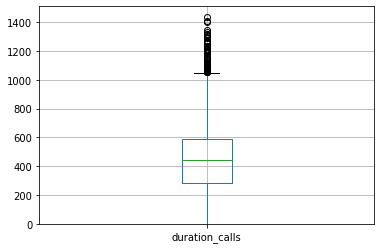

In [26]:
boxplot('duration_calls')

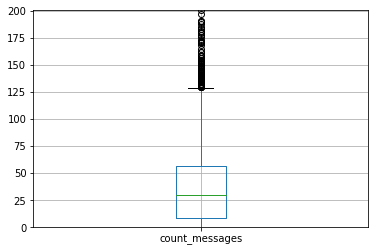

In [27]:
boxplot('count_messages')

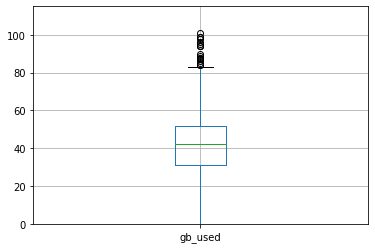

In [28]:
boxplot('gb_used')

Выбросы есть, но их не очень много. И набор данных очень ограничен.
Допустим я определю следующие границы и избавлюсь от выбросов:
- duration_calls - не более 1000 минут в месяц
- count_messages - не более 125 смс сообщений в месяц
- gb_used - не более 80 Гб в месяц

In [29]:
users_all = users_all.query('duration_calls <= 1000')
users_all = users_all.query('count_messages <= 125')
users_all = users_all.query('gb_used <= 80')
users_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3023 entries, 0 to 3213
Data columns (total 19 columns):
user_id                  3023 non-null int64
month                    3023 non-null int64
count_calls              3023 non-null float64
duration_calls           3023 non-null float64
count_messages           3023 non-null float64
gb_used                  3023 non-null float64
city                     3023 non-null object
tariff_name              3023 non-null object
messages_included        3023 non-null int64
gb_per_month_included    3023 non-null int64
minutes_included         3023 non-null int64
rub_monthly_fee          3023 non-null int64
rub_per_gb               3023 non-null int64
rub_per_message          3023 non-null int64
rub_per_minute           3023 non-null int64
over_calls               3023 non-null float64
over_messages            3023 non-null float64
over_gb                  3023 non-null float64
total_revenue            3023 non-null float64
dtypes: float64(8), 

# Шаг 3. Анализ данных <a id='step4'></a>

На предыдущих этапах работы мы получили некую выборку пользователей - клиентов оператора, посчитали показатели, характеризующие поведение клиентов оператора: сколько они тратят минут, сообщений, какой объем трафика по месяцам. 

На этом этапе на основе этой выборки попробуем проанализировать поведение клиентов, использующих разные тарифы, сколько минут, сообщений, интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию, стандартное отклонение, построим гистограммы и опишем распределения.


In [30]:
users['tariff_name'].value_counts()

smart    351
ultra    149
Name: tariff_name, dtype: int64

Пользователей тарифа "Смарт" больше в 2.3 раза - логично, тариф дешевле.

In [31]:
users_all.pivot_table(index='tariff_name', values='total_revenue',aggfunc=['sum','mean'])

,sum,mean
,total_revenue,total_revenue
tariff_name,,
smart,13602537.0,6168.951020
ultra,2943900.0,3598.899756


Общая выручка пользователей тарифа Смарт за весь анализируемый период - 13 602 тыс.руб (38 тыс в среднем на пользователя), Ултра - 2 943 тыс.руб. (~20 тыс.руб. на пользователя). Средняя ежемесячная выручка пользователя тарифа Смарт - 6168 руб, Ультра - 3598 руб.

In [32]:
#средняя ежемесячная выручка всех пользователей тарифа Смарт
users_all.pivot_table(index='month', columns='tariff_name',values='total_revenue',aggfunc='sum')['smart'].mean()

1133544.75

In [33]:
#средняя ежемесячная выручка всех пользователей тарифа Смарт
users_all.pivot_table(index='month', columns='tariff_name',values='total_revenue',aggfunc='sum')['ultra'].mean()

245325.0

Каждый месяц пользователи тарифа Смарт приносят выручки почти в пять раз больше.

Проверим как часто пользователи переплачивают сверх тарифов.

In [34]:
#смарт
len(users_all.query('(total_revenue > rub_monthly_fee)&(tariff_name=="smart")'))/len(users_all.query('tariff_name=="smart"'))
#users_all.pivot_table(index='total_revenue', columns='tariff_name',values='total_revenue',aggfunc='sum')['ultra'].mean()

0.9496598639455782

In [35]:
#ультра
len(users_all.query('(total_revenue > rub_monthly_fee)&(tariff_name=="ultra")'))/len(users_all.query('tariff_name=="ultra"'))

0.589242053789731

Пользователям Смарт, покупая более дешевый тариф, думали, что экономят. Похоже они ошибались.

**ИТОГО: в нашей выборке пользователей тарифа "Смарт" больше в 2.3 раза, в среднем пользователи тарифа "Смарт" мишут меньше смс в месяц, тратят меньше минут на разговоры, а вот интернета тратят в среднем больше. Ежемесячная выручка, которую приносит каждый пользователь "Смарт" больше - эту гипотезу проверим на следующем этапе.**

Рассмотрим более подробно на гистограммах, посчитаем помимо средних дисперсию и отклонение:

In [36]:
#функция построения гистограмм
def hist(column):
    plt.xlabel(column)
    ax = users_all.query('tariff_name=="smart"')[column].plot(kind='hist', bins=30, alpha=0.7, label='smart',legend=True,title=column+' per month')
    users_all.query('tariff_name=="ultra"')[column].plot(kind='hist',bins=30,alpha=0.5,label='ultra',legend=True, ax=ax)
    
# функция для сводных
def pivot(column):
    return users_all.pivot_table(index='tariff_name', values=column,aggfunc=['mean','var','std'])

In [37]:
pivot('duration_calls')

,mean,var,std
,duration_calls,duration_calls,duration_calls
tariff_name,,,
smart,414.629932,34697.170610,186.271765
ultra,479.165037,70022.539437,264.617723


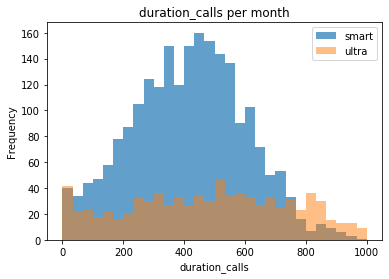

In [38]:
hist('duration_calls')

Большинство пользователей "Смарт" при использовании минут укладываются в тарифный план, но тех, кому не хватает 500 минут в месяц тоже достаточно много и отклонение от среднего достаточно большое. Всем пользователям тарифа "Ультра" с избытком хватает 3000 минут, включенных в тарифный план.

In [39]:
pivot('count_messages')

,mean,var,std
,count_messages,count_messages,count_messages
tariff_name,,,
smart,32.959184,760.541890,27.577924
ultra,37.149144,1169.593396,34.199319


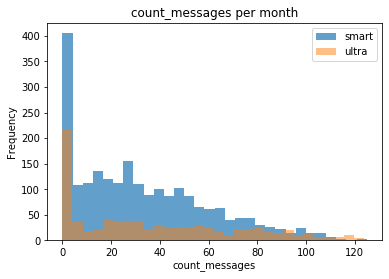

In [40]:
hist('count_messages')

Большинство пользователей "Смарт" укладываются в тарифный план 50 сообщений в месяц, но есть и те, кто не попадает в интервал. Всем пользователям тарифа "Ультра" с избытком хватает 1000 сообщений, включенных в тарифный план. Есть те, кто вообще не пользуется смс, таких вообще в наше время должно быть большинство.

In [41]:
pivot('gb_used')

,mean,var,std
,gb_used,gb_used,gb_used
tariff_name,,,
smart,42.063039,210.161632,14.496953
ultra,35.992665,349.752700,18.701676


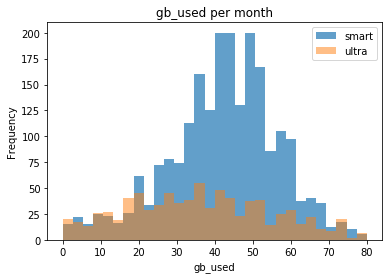

In [42]:
hist('gb_used')

Гигабайт, включенных в тарифы мало кому хватает.

# Шаг 4. Проверка гипотез <a id='step5'></a>

Проверим гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

В данной задаче пороговое значение установим 5%, это будет достаточно.

Проверим первую гипотезу о равенстве средних:
- H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» равна
- H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается


In [43]:
#совокупность 1 с ежемесячными выручками пользователей тарифа Смарт:
smart = users_all.query('tariff_name=="smart"')['total_revenue']
#совокупность 2 с ежемесячными выручками пользователей тарифа Ультра:
ultra = users_all.query('tariff_name=="ultra"')['total_revenue']
results = st.ttest_ind(ultra,smart)
results.pvalue

1.1492648180134494e-118

Вероятность крайне мала, мы можем отвергнуть нулевую гипотезу, и принять алтернативную, что выручка различается

Проверим вторую гипотезу о равенстве средних:
- H0 - средняя выручка пользователей пользователей из Москвы равна средней выручке пользователей из других регионов
- H1 - средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов

In [44]:
#совокупность 1 с ежемесячными выручками пользователей тарифа Смарт:
moscow = users_all.query('city=="Москва"')['total_revenue']
#совокупность 2 с ежемесячными выручками пользователей тарифа Ультра:
other = users_all.query('city=="Другой регион"')['total_revenue']
results = st.ttest_ind(moscow,other )
results.pvalue

0.16656657260343904

Вероятность выше порогового значения. Не получилось отвергнуть нулевую гипотезу о том, что средняя выручка пользователей из Москвы равна средней выручке пользователей из другого региона.

# Общий вывод <a id='step6'></a>

Мы провели предварительный анализ тарифов на небольшой выборке клиентов.
Мы посчитали для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя 

Проанализировали полученные данные и предварительно получили характеристики среднестатистического пользователя каждого тарифа:
пользователей тарифа "Смарт" больше примерна в два раза (абонентская плата ниже, поэтому изначально он привлекательне по цене), в среднем пользователи тарифа "Смарт" мишут меньше смс в месяц, тратят меньше минут на разговоры, а вот интернета тратят в среднем больше, и платят за это сверх тарифа. 

Если ориентироваться только на средние показатели, то ежемесячная выручка пользователя тарифа "Смарт" больше. Но наверняка, мы это утвержадть не можем.
Поэтому стастически мы проверили гипотезу, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается - и не опровергли ее.

Можно ПРЕДПОЛОЖИТЬ, что пользователи тарифа Смарт приносят больше выручки компании.

А также проверили гипотезу, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов - это гипотезу мы отвергли.